# 06. PyTorch Transfer Learning

### What is Transfer Learning?

*Transfer learning* allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take patterns from a computer vision model has learned from datasets and use them to power our own.

We could also take patterns from a language model and use them as the basis of a model to classify different text sample.

The concept is the same: find a well-performing existing model and apply it to your own problem. 

### Why use transfer learning?

There are two main benefits:
1. Can leverage an existing model proven to work on problems similar to our own. 
2. Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data. 

### Where can you find pre-trained models?

There are several places, here are a couple:
* PyTorch domain libraries: Each PyTorch domain comes with pre-trained models of some form. These include `torchvision.models`, `torchtext.models`, `torchaudio.models`, `torchrec.models` and others. 
* HuggingFaceHub: A series of pre-trained models of diverse domains (https://huggingface.co/models)
* `timm` (PyTorch Image Models library): Most of the best PyTorch computer vision models and useful features are found here (https://github.com/rwightman/pytorch-image-models)
* Paperswithcode: A collection of the latest state-of-the-art machine learning papers. You can also find benchmarks of model performance on different tasks (https://paperswithcode.com/)

## 0. Setup

We will start by importing and downloading the required modules.

We will use the Python scripts we have in the `going_modular` folder as well. 

In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.2
torchvision version: 0.17.2


In [39]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo. Installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
except:
    print("[INFO] Could not find going_modular scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch
    !mv Zero-To-Mastery-Pytorch/Fundamentals/going_modular .
    !rm -rf Zero-To-Mastery-Pytorch
    from going_modular import data_setup, engine



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

We will continue using the `pizza_steak_sushi.zip` dataset for this project.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Datasets and DataLoaders

We can leverage the `data_setup.py` file from the `going_modular` section, but since we will use a pre-trained model from `torchvision.models`, the images need to undergo a specific transform first.

### 2.1 Manually creating a transform for `torchvision.models`

Whenever using a pre-trained model, it is always important for the custom data going into the model to be prepared in the same way as the original training data went into the model. 

In the following link is the description of the data preparation:
https://pytorch.org/hub/pytorch_vision_resnet/

In summary, images have to be normalized in batches of 3-channel RBG images of shape (3 x H x W) where H and W are expected to be at least 224.

Furthermore, the images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

Using `torchvision.transforms.Resize()` allows us to resize images into `[3, 224, 224]` while `torch.utils.data.DataLoader` allows us to create the batches of images.

`torchvision.transforms.ToTensor()` makes the data be between 0 and 1.

`torchvision.transforms.Normalize(mean=...)` and `torchvision.transforms.Normalize(std=...)` allows us to adjust the mean and standard deviation of the images. 


In [7]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1614f4910>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

When preparing data, aside from performing the right transformation, one can also select the pre-trained model weights that one would like to use. Given this,
* `EfficientNet_B0_Weights` is the model architecture weights we would like to use (there are many different model architecture options in `torchvision.models`)
* `DEFAULT` means the best available weights (the best performance in ImageNet). Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2`, where generally the higher the version number the better. However, if you want the best available, `DEFAULT` is the best option.

Within the `EfficientNet` weights, there are currently versions from `B0` until `B7`. The difference between these versions is that the higher it is, the greater the size and complexity in terms of input resolution, depth, width, parameters, performance and inference speed on the GPU. While `B7` has the greatest performance (~84.4%) `B0` is the fastest with a significant accuracy (~77.1%).

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

To see the transforms associated with the `weights`, we can use the `transforms()` method which essentially gets the data transforms that was used to train the weights.

In [10]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The used transforms are very similar as the `manual_transforms` except that `auto_transforms` already came with the model architecture we chose. 

Using `weights.transforms()` ensures you are using the same data transformation as the pre-trained model when it was trained. However, the trade off is a lack of customization.

Hence, we can also directly use `weights.transforms()` for our dataloaders. 

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x161ac4450>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pre-trained model

The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customize it to your use case. 

Since we are tackling a computer vision problem (image classification with FoodVision Mini), we can find pre-trained classification models in `torchvision.models`. Here are a couple of common computer vision architecture backbones:

* RestNet: `torchvision.models.resnet18()`, `torchvision.models.resnet50()`
* VGG: `torchvision.models.vgg16()`
* EfficientNet: `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`
* VisionTransformer: `torchvision.models.vit_b_16()`, `torchvision.models..vit_b_32()`
* ConvNeXt: `torchvision.models.convnext_tiny()`, `torchvision.models.convnext_small()`

### 3.1 Which pre-trained model should you use?

Generally, the higher number in the model name means better performance but a larger model. While higher performance is desired, some better performing models are too big for some devices. 

Understanding your device's limitations is part of the performance vs speed vs size tradeoff that comes with time and practice. 

### 3.2 Setting up a pre-trained model

The architecture to be used is from this paper:
https://arxiv.org/pdf/1905.11946

In [13]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/aaronserpilin/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 11.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

`efficientnet_b0` comes in three main parts:
1. `features` - a collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images")
2. `avgpool` - takes the average of the output of the `features` layer(s) and turns it into a feature vector.
3. `classifier` - turns the feature vector into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pre-trained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

To learn more, we can use `torchinfo`'s `summary()` method. 

To do so, we pass in the following parameters:

* `model` - the model we would like to get a summary of
* `input_size` - the shape of the data we would like to pass to our model. For `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though other variants have different input sizes
* `col_names` - the various information columns we would like to see about our model
* `col_width` - how wide the columns should be for the summary
* `row_settings` - what features to show in a row

In [14]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

For reference, in the other files where the TinyVGG model was used, TinyVGG had 8,083 parameters. However, `efficientnet_b0` has 5,2888,548 parameters.

### 3.4 Freezing the base model and changing the output layer to suit our needs

When doing transfer learning, the process usually goes like this:
1. Freeze some base layers of a pre-trained model (typically the `features` section)
2. Adjust the output layers (also called head/classifier layers) to suit your needs

For instance, `torchvision.models.efficient_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, which is the dataset it was trained on. For this notebook however, we only need `out_features=3` for the pizza, steak, and sushi classes. 

Freezing layers from the model means preventing it from learning or updating its weights during training. Specifically,
* During backpropagation, the gradients for frozen layers are not calculated
* Frozen layers retain the weights they hade from the pre-trained model

Freezing layers allows to model to preserve pre-trained knowledge, reduce computational cost, and avoid over-fitting. 

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

In [21]:
for param in model.features.parameters():
    param.requires_grad = False

Seen in the summary section above, our current `classifier` consists of a `Dropout` and `Linear` layers. `Dropout` layers randomly remove connections between two neural networks with a probability of `p` to help regularize and prevent overfitting by making sure the connections that remain learn features to compensate for the removal of the other connections. 

We will keep `in_features=1280` for the `Linear` output layer but change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [23]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

The main changes in the summary are as follows:
* Trainable column: Many of the base layers (except the last `Dropout` and `Linear` layers) have their trainable value as `False`. This is due to the layer freezing, meaning these layers will not be updated during future training.
* Output shape of `classifier`: The output shape of the `classifier` portion is now `[32, 3]` instead of `[32, 1000]`. Trainable is `True` for these, meaning its parameters will be updated during training. Essentially, the `features` portion feeds the classifier a base representation of an image, and the `classifier` determines how said representation aligns with the problem. 
* Less trainable parameters: Previously there were 5,288,548 parameters. After freezing many layers, we now have 3,843 parameters. The 4,007,548 non-trainable parameters will create the base representation of our input images for the `classifier` layer. 

## 4. Train model

Now we can train our semi-frozen model with a customized classifier.

Since this is multi-class classification, we use `nn.CrossEntropyLoss()` for the loss function and `torch.optim.Adam()` as our optimizer with `lr=0.001`.

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3658 | train_acc: 0.9609 | test_loss: 0.1961 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.4183 | train_acc: 0.9414 | test_loss: 0.2128 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.4189 | train_acc: 0.9648 | test_loss: 0.1883 | test_acc: 0.8362
Epoch: 4 | train_loss: 0.3692 | train_acc: 0.9570 | test_loss: 0.1717 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.3108 | train_acc: 0.9727 | test_loss: 0.1820 | test_acc: 0.8561
[INFO] Total training time: 420.799 seconds


Using the `efficientnet_b0` backbone, the model achieves essentially 85%+ accuracy on the test dataset, whereas the TinyVGG model struggled to surpass the 55%+ mark. 

## 5. Evaluate model by plotting loss curves

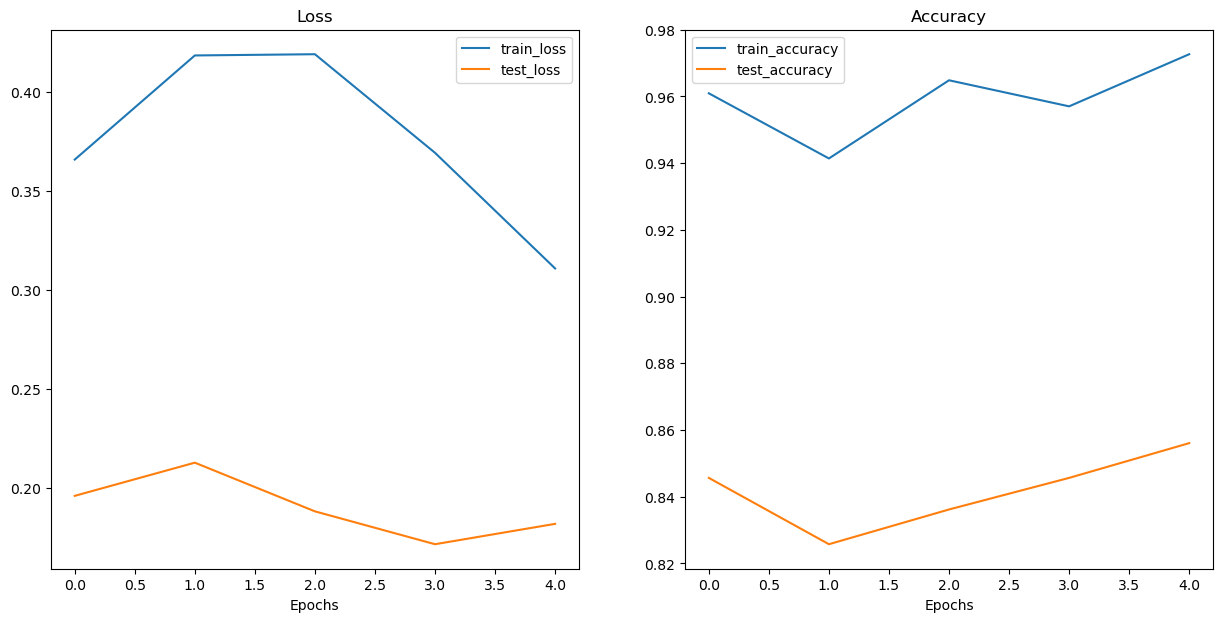

In [36]:
try:
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] Could not find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch/refs/heads/main/Fundamentals/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

The data seems to be heading in the right direction. The scales might be slightly misleading, but the loss of both are converging, while the accuracy is increasing as well. Hence, it shows the power of transfer learning where using a pre-trained model lead to good results with little amount of data and coding. 

## 6. Making predictions on images from the test set

In order to make predictions, we need to make sure our images meet the following parameters:
* Same shape
* Same datatype
* Same device
* Same transformations

These requirements however, are not exclusive to this model. These requirements go for all kinds of data if you are trying to make predictions with a trained model. Data you would like to predict on should be in the same format as your model was trained on. 

To do all this, we will make a function that does the following:
1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform, and a target device
2. Open an image with `PIL.Image.open()`
3. Create a transform for the image (using the `manual_transforms` we created above or using a transform from `weights.transforms()`)
4. Make sure the model is on the target device
5. Turn on `model.eval()` (turning off layers such as `Dropout` which are not used for inference) and the inference mode context manager
6. Transform the target image with the transform and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction 
8. Convert the model's output logits to prediction probabilities with `torch.softmax()` and then to prediction labels with `torch.argmax()`
9. Plot the image with `matplotlib`

In [43]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    model.to(device)
    model.eval()

    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)



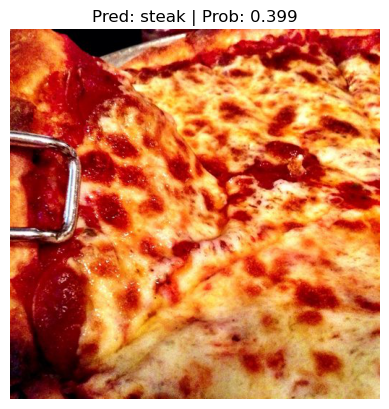

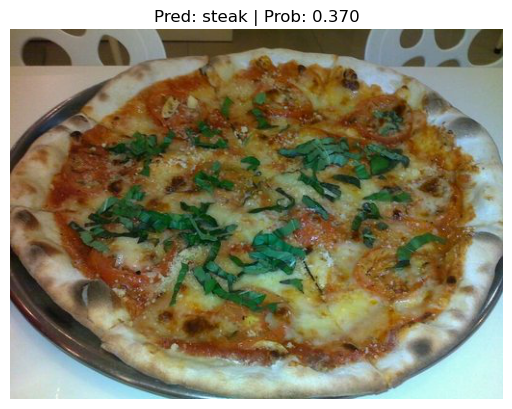

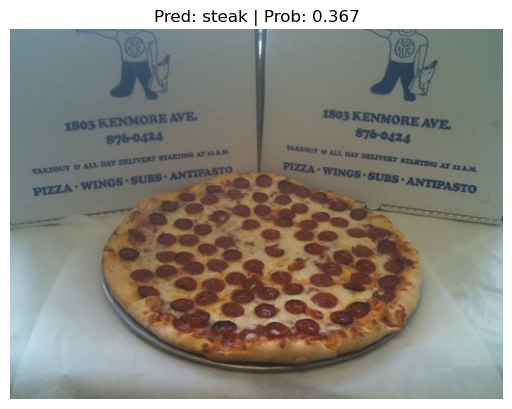

In [44]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))